Dimensions: 2, Dataset Size: 1000
Naive - Training Time: 0.0015 seconds, Testing Time: 0.0362 seconds,Training Memory:40.9834Kb,Testing Memory:41.8350Kb, Accuracy: 0.9350
KD-Tree - Training Time: 0.0005 seconds, Testing Time: 0.0034 seconds,Training Memory:16.8477Kb,Testing Memory:35.8555Kb, Accuracy: 0.9350
LSH - Training Time: 0.2664 seconds, Testing Time: 0.0286 seconds,Training Memory:3985.4688Kb,Testing Memory:58.0625Kb, Accuracy: 0.9200

Dimensions: 2, Dataset Size: 5000
Naive - Training Time: 0.0014 seconds, Testing Time: 0.1802 seconds,Training Memory:193.9834Kb,Testing Memory:154.2754Kb, Accuracy: 0.9030
KD-Tree - Training Time: 0.0016 seconds, Testing Time: 0.0121 seconds,Training Memory:66.8477Kb,Testing Memory:156.7139Kb, Accuracy: 0.9030
LSH - Training Time: 0.2234 seconds, Testing Time: 0.5743 seconds,Training Memory:4096.9785Kb,Testing Memory:206.6914Kb, Accuracy: 0.9090

Dimensions: 2, Dataset Size: 10000
Naive - Training Time: 0.0017 seconds, Testing Time: 0.3648 secon

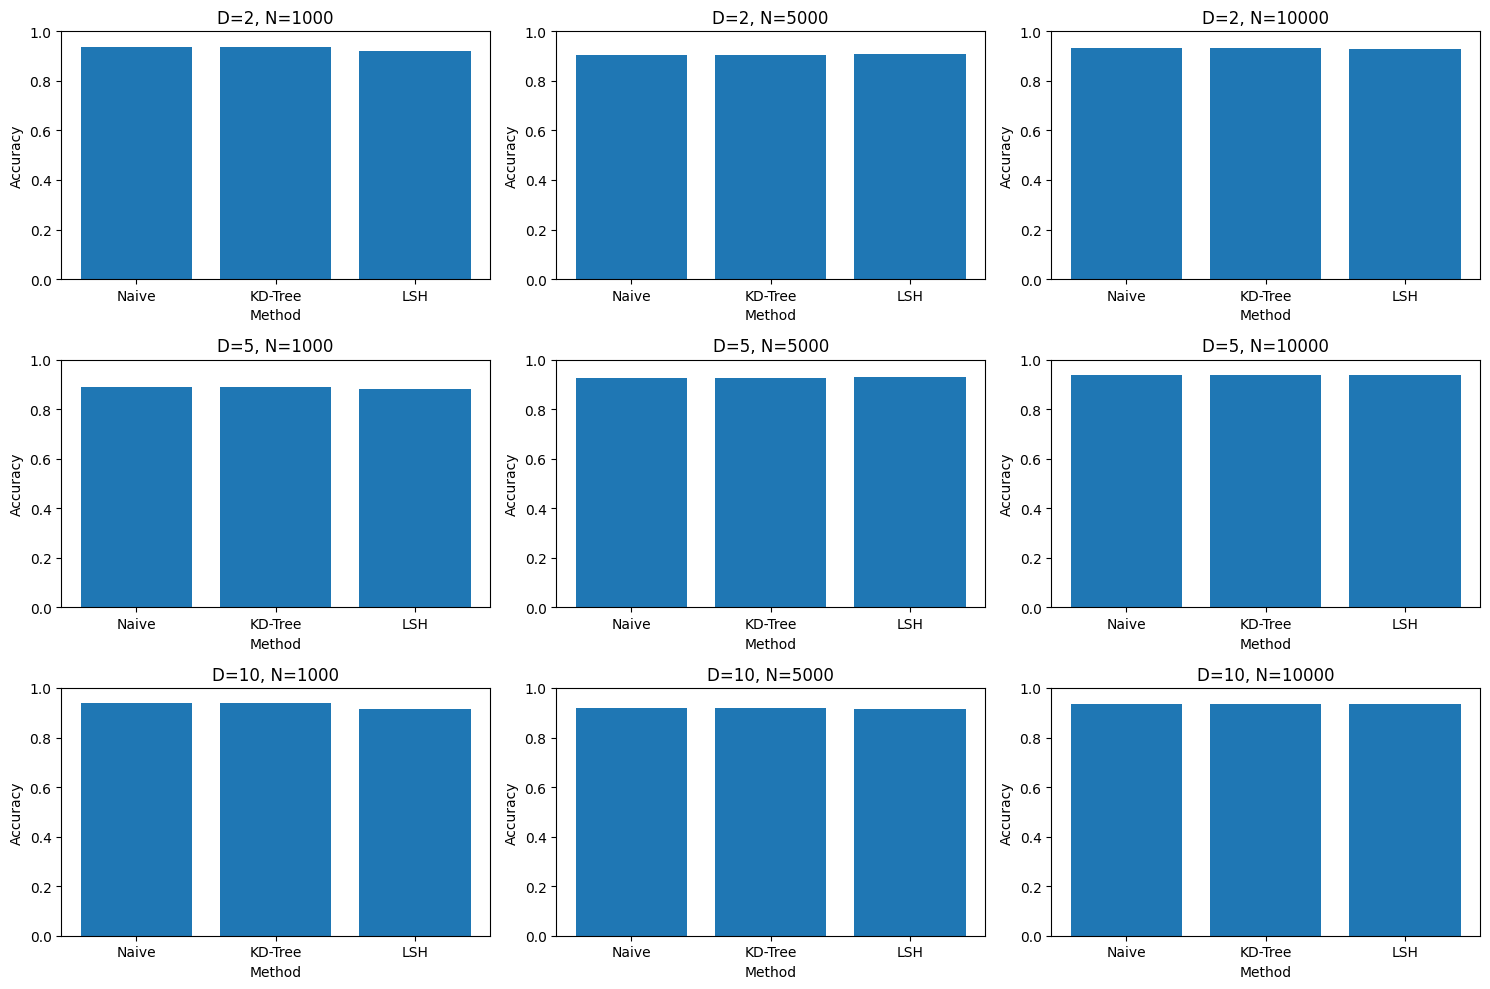

In [16]:
# Import necessary libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier, KDTree, NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tracemalloc

# Step 1: Implementing KNN Variants with Varying Dataset Size and Number of Dimensions

class LSH:
    def __init__(self, data, num_bits=10):
        self.num_bits = num_bits
        self.data = data
        self.hyperplanes = np.random.randn(data.shape[1], num_bits)
        self.buckets = {i: [] for i in range(2**num_bits)}

        for index, point in enumerate(data):
            hash_value = self.calculate_hash_value(point)
            self.buckets[hash_value].append(index)

    def calculate_hash_value(self, point):
        boolean_values = (point @ self.hyperplanes > 0).astype(int)
        hash_value = sum([boolean_values[i] << i for i in range(self.num_bits)])
        return hash_value

    def query(self, point, k=1):
        hash_value = self.calculate_hash_value(point)
        bucket_indices = self.buckets[hash_value]
        bucket_data = self.data[bucket_indices]
        distances = np.linalg.norm(bucket_data - point, axis=1)
        nearest_k_indices = np.argsort(distances)[:k]
        nearest_k_data_indices = [bucket_indices[i] for i in nearest_k_indices]

        return nearest_k_data_indices



def measure_knn_performance(X_train, y_train, X_test, y_test, k):
    # Naive KNN
    start_time = time.time()
    tracemalloc.start()
    naive_knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    naive_knn.fit(X_train, y_train)
    naive_train_time = time.time() - start_time
    _, memory_naive = tracemalloc.get_traced_memory()
    naive_train_memory = memory_naive / 1024  # Convert to KB
    tracemalloc.stop()


      #Test
    tracemalloc.start()
    start_time = time.time()
    naive_y_pred = naive_knn.predict(X_test)
    naive_accuracy = accuracy_score(y_test, naive_y_pred)
    naive_test_time = time.time() - start_time
    _, memory_naive = tracemalloc.get_traced_memory()
    naive_test_memory = memory_naive / 1024  # Convert to KB
    tracemalloc.stop()

    # KD-Tree KNN
    tracemalloc.start()
    start_time = time.time()
    tracemalloc.start()
    kdtree = KDTree(X_train, leaf_size=30, metric='euclidean')
    kdtree_train_time = time.time() - start_time
    _, memory_kd = tracemalloc.get_traced_memory()
    kd_train_memory = memory_kd / 1024  # Convert to KB
    tracemalloc.stop()

    #Test
    tracemalloc.start()
    start_time = time.time()
    _, ind = kdtree.query(X_test, k=k)
    kdtree_y_pred = [np.argmax(np.bincount(y_train[neighbors])) for neighbors in ind]
    kdtree_accuracy = accuracy_score(y_test, kdtree_y_pred)
    kdtree_test_time = time.time() - start_time
    _, memory_kd = tracemalloc.get_traced_memory()
    kd_test_memory = memory_kd / 1024  # Convert to KB
    tracemalloc.stop()

    # LSH KNN
    start_time = time.time()
    tracemalloc.start()
    # lsh = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
    # lsh.fit(X_train)
    lsh = LSH(X_train, num_bits=15)
    lsh_train_time = time.time() - start_time
    _, memory_lsh = tracemalloc.get_traced_memory()
    lsh_train_memory = memory_lsh / 1024  # Convert to KB
    tracemalloc.stop()

    #Test
    tracemalloc.start()
    start_time = time.time()
    neighbors = []
    for x in X_test:
      neighbors.append(lsh.query(x, k=k))
    # lsh_y_pred = [np.argmax(np.bincount(y_train[neighbors[i]])) for i in range(len(X_test))]
    lsh_y_pred = [np.argmax(np.bincount(y_train[neighbors[i]])) if neighbors[i] else np.argmax(np.bincount(y_train)) for i in range(len(X_test))]

    lsh_accuracy = accuracy_score(y_test, lsh_y_pred)
    lsh_test_time = time.time() - start_time
    _, memory_lsh = tracemalloc.get_traced_memory()
    lsh_test_memory = memory_lsh / 1024  # Convert to KB
    tracemalloc.stop()

    return {
        "Naive": {"Training Time": naive_train_time,"Testing Time": naive_test_time,"Training Memory": naive_train_memory,"Testing Memory": naive_test_memory, "Accuracy": naive_accuracy},
        "KD-Tree": {"Training Time": kdtree_train_time,"Testing Time": kdtree_test_time, "Training Memory": kd_train_memory,"Testing Memory": kd_test_memory,"Accuracy": kdtree_accuracy},
        "LSH": {"Training Time": lsh_train_time, "Testing Time": lsh_test_time, "Training Memory": lsh_train_memory,"Testing Memory": lsh_test_memory,"Accuracy": lsh_accuracy}
    }

def vary_dataset_size_and_dimensions():
    dimensions = [2, 5, 10]  # Number of dimensions
    dataset_sizes = [1000, 5000, 10000]  # Dataset sizes
    k = 5  # Number of neighbors

    results = {}

    for D in dimensions:
        for N in dataset_sizes:
            informative_features = min(D, 2)
            redundant_features = max(0, D - informative_features)
            repeated_features = 0
            X, y = make_classification(n_samples=N, n_features=D, n_classes=2, n_informative=informative_features, n_redundant=redundant_features, n_repeated=repeated_features, random_state=42)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            result = measure_knn_performance(X_train, y_train, X_test, y_test, k)
            results[(D, N)] = result

    return results

# Run the experiments
results = vary_dataset_size_and_dimensions()

# Print and visualize the results
for key, value in results.items():
    print(f"Dimensions: {key[0]}, Dataset Size: {key[1]}")
    for method, metrics in value.items():
        print(f"{method} - Training Time: {metrics['Training Time']:.4f} seconds, Testing Time: {metrics['Testing Time']:.4f} seconds,Training Memory:{metrics['Training Memory']:.4f}Kb,Testing Memory:{metrics['Testing Memory']:.4f}Kb, Accuracy: {metrics['Accuracy']:.4f}")
    print()
# Plot the results
dimensions = [2, 5, 10]  # Number of dimensions
dataset_sizes = [1000, 5000, 10000]  # Dataset sizes

fig, axes = plt.subplots(len(dimensions), len(dataset_sizes), figsize=(15, 10))

for i, D in enumerate(dimensions):
    for j, N in enumerate(dataset_sizes):
        # Get the results for this configuration
        result = results[(D, N)]
        accuracies = [result[method]['Accuracy'] for method in result]
        training_times = [result[method]['Training Time'] for method in result]
        methods = list(result.keys())

        # Plot the accuracies
        axes[i, j].bar(methods, accuracies)
        axes[i, j].set_title(f"D={D}, N={N}")
        axes[i, j].set_ylim(0, 1)
        axes[i, j].set_ylabel("Accuracy")
        axes[i, j].set_xlabel("Method")

plt.tight_layout()
plt.show()
